In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import lhapdf

In [37]:
pdfset = 'cteq61'
Mp = 0.938

class A0(tf.keras.layers.Layer):
    def __init__(self, kperp2avg=.57, pperp2avg=.12, **kwargs):
        super(A0, self).__init__(name='a0')
        self.m1 = tf.Variable(1., name='m1')
        self.kperp2avg = kperp2avg
        self.pperp2avg = pperp2avg
        self.e = tf.constant(1.)

    def get_config(self):
        config = super().get_config().copy()

        config.update({
            'kperp2avg': self.kperp2avg,
            'pperp2avg': self.pperp2avg
        })

        return config

    def call(self, inputs):
        z = inputs[:, 0]
        pht = inputs[:, 1]
        ks2avg = (self.kperp2avg*self.m1**2)/(self.m1**2 + self.kperp2avg) #correct
        topfirst = (z**2 * self.kperp2avg + self.pperp2avg) * ks2avg**2 #correct
        bottomfirst = (z**2 * ks2avg + self.pperp2avg)**2 * self.kperp2avg #correct
        exptop = pht**2 * z**2 * (ks2avg - self.kperp2avg) #correct
        expbottom = (z**2 * ks2avg + self.pperp2avg) * (z**2 * self.kperp2avg + self.pperp2avg) #correct
        last = tf.sqrt(2*self.e) * z * pht / self.m1 #correct
        return (topfirst/bottomfirst) * tf.exp(-exptop/expbottom) * last


class Quotient(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Quotient, self).__init__()

    def call(self, inputs):
        if len(inputs) != 2 or inputs[0].shape[1] != 1:
            raise Exception('must be two tensors of shape (?, 1)')
        return inputs[0]/inputs[1]
    
    
def nnq(model, x, hadronstr):
    if not hadronstr in ['nnu', 'nnd', 'nns', 'nnubar', 'nndbar', 'nnsbar']:
        raise Exception('hadronstr must be one of nnu, nnd, nns, nnubar, nndbar, nnsbar')
    mod_out = tf.keras.backend.function(model.get_layer(hadronstr).input,
                                       model.get_layer(hadronstr).output)
    return mod_out(x)

def pdf_vals(flavor, x, QQ):
    pdfData = lhapdf.mkPDF(pdfset)
    return np.array([pdfData.xfxQ2(flavor, ax, qq) for ax, qq in zip(x, QQ)])

def h(model, kperp):
    m1 = model.get_layer('a0').m1.numpy()
    e = model.get_layer('a0').e.numpy()
    return np.sqrt(2*e) * (kperp/m1) * np.exp(-kperp**2/m1**2)

def fqp(x, QQ, kperp2avg, kperp, flavor):
    fq = pdf_vals(flavor, x, QQ)
    return fq*(1/(np.pi*kperp2avg))*np.exp(-kperp**2/kperp2avg)


def xSivFunction(model, x, QQ, kperp2avg, flavor, kperp):
    refDict = {-3: 'nnsbar',
               -2: 'nnubar',
               -1: 'nndbar',
               1: 'nnd',
               2: 'nnu',
               3: 'nns'}
    nnqval = nnq(model, np.array([x]), refDict[flavor])
    #nnqval = nnq(model , np.array([x]), refDict[flavor])[:,0]
    hval = h(model, kperp)
    fqpval = fqp([x], [QQ], kperp2avg, kperp, flavor)
    return ((2*nnqval*hval*fqpval)[0, :])


def kval(kx,ky):
    return np.sqrt(kx**2 + ky**2)


def density_func(model, x, QQ, kperp2avg, flavor, kxx, kyy):
    kTval = kval(kxx,kyy)
    return fqp(x, QQ, kperp2avg, kTval, flavor) - (kxx/Mp)*xSivFunction(model, x, QQ, kperp2avg, flavor, kTval)

In [22]:
tt = tf.keras.models.load_model('NN_SIDIS_Models/rep0.h5',custom_objects={'A0': A0, 'Quotient': Quotient})

In [26]:
print(kval(2,2))

2.8284271247461903


In [27]:
print(np.array(list(range(150)))/100)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49]


In [31]:
kxv = np.array(np.linspace(-1,1,100))
kyv = np.array(np.linspace(-1,1,100))
kTv = kval(kxv,kyv)
h(tt, kTv)

array([0.60653049, 0.60626847, 0.60550203, 0.60422215, 0.60242047,
       0.60008934, 0.59722183, 0.59381178, 0.5898538 , 0.58534331,
       0.58027655, 0.57465063, 0.56846353, 0.56171409, 0.55440211,
       0.54652825, 0.53809416, 0.52910239, 0.51955646, 0.50946084,
       0.49882097, 0.48764324, 0.475935  , 0.46370457, 0.45096119,
       0.43771508, 0.42397735, 0.40976007, 0.39507617, 0.37993949,
       0.36436473, 0.34836742, 0.33196392, 0.31517137, 0.29800766,
       0.28049143, 0.26264199, 0.24447933, 0.22602406, 0.20729735,
       0.18832095, 0.16911708, 0.14970843, 0.13011811, 0.11036959,
       0.09048666, 0.07049338, 0.05041403, 0.03027309, 0.01009515,
       0.01009515, 0.03027309, 0.05041403, 0.07049338, 0.09048666,
       0.11036959, 0.13011811, 0.14970843, 0.16911708, 0.18832095,
       0.20729735, 0.22602406, 0.24447933, 0.26264199, 0.28049143,
       0.29800766, 0.31517137, 0.33196392, 0.34836742, 0.36436473,
       0.37993949, 0.39507617, 0.40976007, 0.42397735, 0.43771

In [38]:
test_density = density_func(tt, [0.1], [2], 0.57, 2, kxv, kyv)

In [40]:
print(test_density)

[0.01387417 0.01588879 0.0181402  0.0206473  0.02342919 0.02650495
 0.02989341 0.0336129  0.03768099 0.04211418 0.0469276  0.05213466
 0.05774678 0.063773   0.07021973 0.07709035 0.08438501 0.09210026
 0.10022891 0.10875973 0.11767738 0.1269622  0.13659022 0.14653311
 0.15675825 0.1672288  0.17790393 0.18873899 0.19968582 0.21069309
 0.22170667 0.23267011 0.24352505 0.25421182 0.26466986 0.27483841
 0.28465696 0.2940659  0.30300705 0.31142425 0.31926388 0.32647539
 0.33301176 0.33883001 0.34389158 0.34816269 0.3516147  0.35422435
 0.355974   0.35685181 0.356816   0.35565277 0.35333786 0.34989416
 0.34535551 0.33976617 0.33318008 0.32565997 0.31727638 0.3081065
 0.29823303 0.28774291 0.27672601 0.2652739  0.25347855 0.24143113
 0.22922086 0.21693396 0.20465272 0.1924546  0.18041158 0.16858956
 0.15704792 0.14583922 0.13500902 0.12459582 0.11463116 0.10513975
 0.09613978 0.08764322 0.07965627 0.07217982 0.06520993 0.0587384
 0.05275327 0.0472394  0.04217898 0.03755206 0.03333703 0.029511

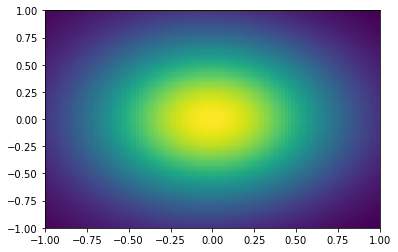

[[0.01387417 0.01481319 0.01579209 ... 0.00876273 0.00811053 0.00749616]
 [0.01465086 0.01564633 0.01668452 ... 0.00965516 0.00894368 0.00827285]
 [0.01546642 0.01652117 0.0176216  ... 0.01059225 0.00981851 0.0090884 ]
 ...
 [0.01546642 0.01652117 0.0176216  ... 0.01059225 0.00981851 0.0090884 ]
 [0.01465086 0.01564633 0.01668452 ... 0.00965516 0.00894368 0.00827285]
 [0.01387417 0.01481319 0.01579209 ... 0.00876273 0.00811053 0.00749616]]
[[0.00298154 0.00329182 0.00362719 ... 0.01309251 0.01231723 0.0115698 ]
 [0.0035104  0.00385912 0.00423485 ... 0.01370017 0.01288453 0.01209866]
 [0.00406572 0.00445481 0.00487293 ... 0.01433825 0.01348022 0.01265398]
 ...
 [0.00406572 0.00445481 0.00487293 ... 0.01433825 0.01348022 0.01265398]
 [0.0035104  0.00385912 0.00423485 ... 0.01370017 0.01288453 0.01209866]
 [0.00298154 0.00329182 0.00362719 ... 0.01309251 0.01231723 0.0115698 ]]


In [56]:
# Sample data
side = np.linspace(-1,1,100)
kxv, kyv = np.meshgrid(side,side)
Zu = density_func(tt, [0.1], [2], 0.57, 2, kxv, kyv)
# Plot the density map using nearest-neighbor interpolation
#plt.pcolormesh(kxv,kyv,Zu)
plt.pcolormesh(kxv,kyv,Zu)
plt.show()
print(Zu)
print(Zd)

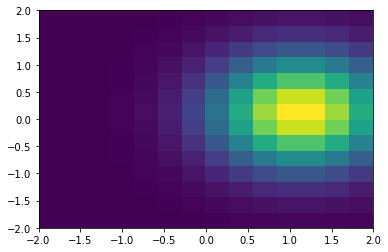

In [45]:
# Sample data
side = np.linspace(-2,2,15)
X,Y = np.meshgrid(side,side)
Z = np.exp(-((X-1)**2+Y**2))

# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.show()